In [825]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import sklearn.model_selection
import arviz

torch.set_default_tensor_type(torch.DoubleTensor)
smoke_test = False

Warmup:   0%|                                             | 0/510 [06:15, ?it/s]


In [586]:
# note that this helper function does three different things:
# (i) plots the observed data;
# (ii) plots the predictions from the learned GP after conditioning on data;
# (iii) plots samples from the GP prior (with no conditioning on observed data)


def plot(
    plot_observed_data=False,
    plot_predictions=False,
    plot_target_function=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None,
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_target_function:
        ax.plot(torch.linspace(-0.5,5.5, n_test), g(torch.linspace(-0.5,5.5, n_test)))
    if plot_observed_data:
        ax.plot(X.numpy(), y.numpy(), "kx")
    if plot_predictions:
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(Xtest.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        ax.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    ax.set_xlim(-0.2, 1.2)

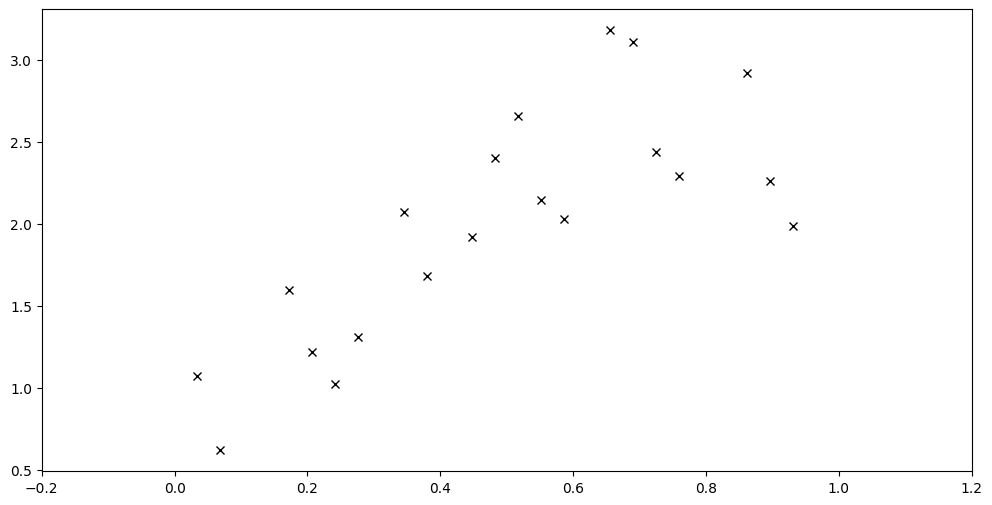

In [588]:
N = 20
N_test = 10
X_all = torch.linspace(0,1,30)
y_all = g(X_all) + dist.Normal(0.0, np.sqrt(0.01)).sample(sample_shape=(30,))

X, X_test, y, y_test = sklearn.model_selection.train_test_split(X_all, y_all, test_size=10)
def g(x):
    return - torch.sin(6*torch.pi*x)**2 + 6 * x**2 - 5*x**4 + 3 / 2
#y = g(X) + dist.Normal(0.0, np.sqrt(0.01)).sample(sample_shape=(N,))
#X_test = dist.Uniform(0.0, 1.0).sample(sample_shape=(N_test,))
#y_test = g(X_test) + dist.Normal(0.0, np.sqrt(0.01)).sample(sample_shape=(N_test,))

plot(plot_observed_data=True)  # let's plot the observed data

In [791]:
pyro.clear_param_store()
linear = gp.kernels.Linear(
    input_dim=1,
)
periodic = gp.kernels.Periodic(
    input_dim=1
)
#rbf = gp.kernels.RBF(
#    input_dim=1#, lengthscale=torch.tensor(1.5), variance=torch.tensor(0.5)
#)
k1 = periodic
#k1 = gp.kernels.Product(kern0=rbf, kern1=periodic)

k = gp.kernels.Sum(linear, k1)
model = gp.models.GPRegression(
    X=X,
    y=y,
    kernel=k,
    jitter=2e-3,
)
# note that our priors have support on the positive reals
model.kernel.kern0.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))

model.kernel.kern1.period = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
model.kernel.kern1.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
model.kernel.kern1.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))

#model.kernel.period = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
#model.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
#model.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))

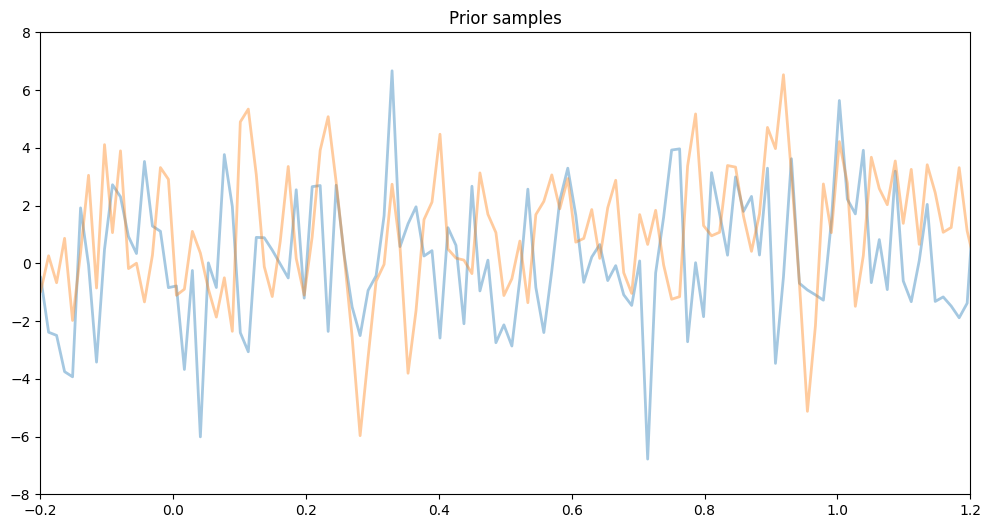

In [754]:
plot(model=model, kernel=k, n_prior_samples=2)
plt.title('Prior samples')
_ = plt.ylim((-8, 8))

In [792]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
joints = []
num_steps = 2000 if not smoke_test else 2
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(model.model, model.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    theta = torch.tensor([model.kernel.kern0.variance, model.kernel.kern1.period, model.kernel.kern1.variance, model.kernel.kern1.lengthscale])
    joints.append(joint(y, theta, X))

Text(0.5, 1.0, 'Loss')

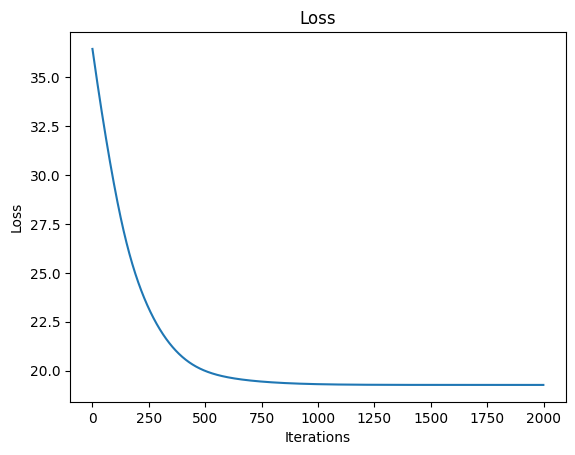

In [793]:
# let's plot the loss curve after 2000 steps of training
def plot_loss(loss):
    plt.plot(loss)
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")  # supress output text


plot_loss(losses)
plt.title('Loss')

Text(0.5, 1.0, 'log-joints')

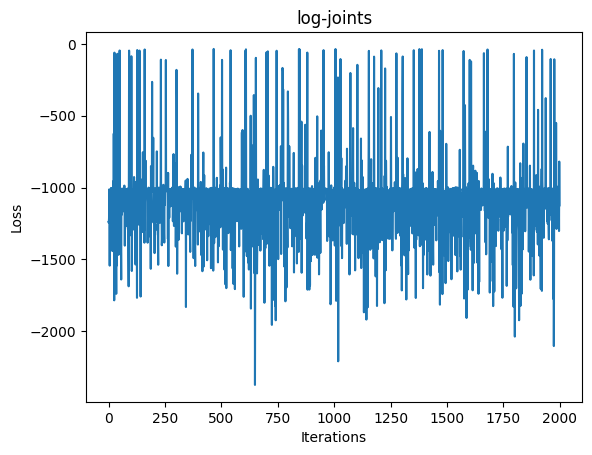

In [789]:
plot_loss(torch.tensor(joints))
plt.title('log-joints')

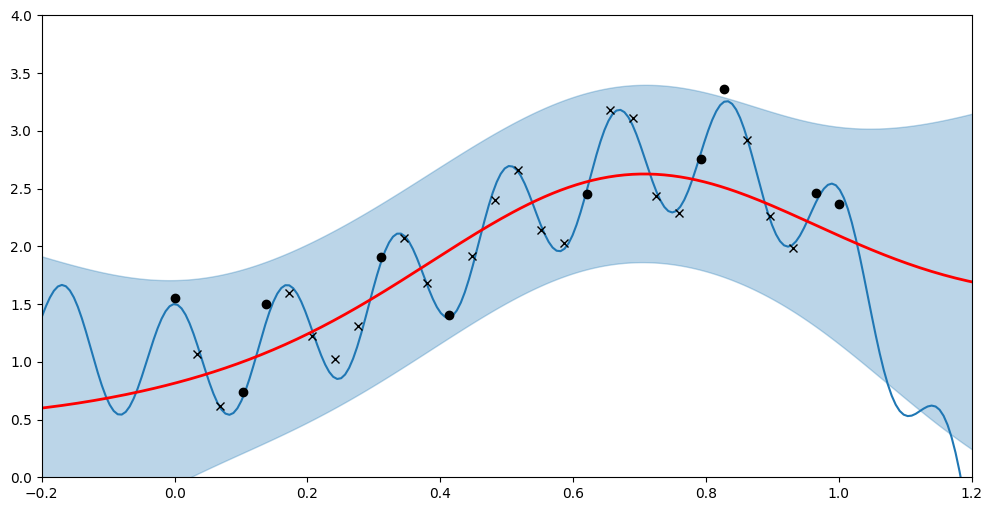

In [794]:
plot(model=model, plot_observed_data=True, plot_predictions=True, plot_target_function=True, n_test=1000)
plt.plot(X_test, y_test, "ko")
_ = plt.ylim((0,4))

In [763]:
theta = torch.tensor([model.kernel.kern0.variance, model.kernel.kern1.period, model.kernel.kern1.variance, model.kernel.kern1.lengthscale])

In [764]:
def joint(y, theta, X):
    with torch.no_grad():
        linear = gp.kernels.Linear(
            input_dim=1,
            variance=theta[0]
        )
        periodic = gp.kernels.Periodic(
            input_dim=1,
            period=theta[1],
            lengthscale=theta[2],
            variance=theta[3]
        )
        k1 = periodic
        k = gp.kernels.Sum(linear, k1)
        priors = torch.distributions.MultivariateNormal(torch.zeros(4), torch.eye(4)).log_prob(theta)
        
        return torch.distributions.MultivariateNormal(torch.zeros(len(y)), linear.forward(X) + k1.forward(X) + torch.eye(X.size(0))*1e-3).log_prob(y) + priors
joint(y_test, torch.tensor([0.4,0.6,0.3,0.9]), X_test)

tensor(-21.1375)

In [795]:
def posterior(y, theta, X):
    with torch.no_grad():
        linear = gp.kernels.Linear(
            input_dim=1,
            variance=theta[0]
        )
        periodic = gp.kernels.Periodic(
            input_dim=1,
            period=theta[1],
            lengthscale=theta[2],
            variance=theta[3]
        )
        k1 = periodic
        k = gp.kernels.Sum(linear, k1)
        priors = torch.distributions.MultivariateNormal(torch.zeros(4), torch.eye(4)).log_prob(theta)
        
        return torch.distributions.MultivariateNormal(torch.zeros(len(y)), linear.forward(X) + k1.forward(X) + torch.eye(X.size(0))*1e-3).log_prob(y) + priors

In [742]:
mu, sigma = model.forward(X_test, full_cov=True)
torch.distributions.MultivariateNormal(mu, sigma).log_prob(y_test)

tensor(-136684.7798, grad_fn=<SubBackward0>)

In [801]:
import pyro.infer

In [830]:
nuts_kernel=pyro.infer.NUTS(model.model, jit_compile=False)
mcmc=pyro.infer.MCMC(nuts_kernel, num_samples=100, num_chains=1, warmup_steps=100)
# Run on training set
mcmc.run()

Sample: 100%|██| 200/200 [00:05, 37.08it/s, step size=5.02e-01, acc. prob=0.882]


/home/rasmuslovstad/Programs/assignments/pml/exam/venv/lib64/python3.11/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (1, 100), minimum_shape: (chains=2, draws=4)


                           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  \
kernel.kern0.variance     1.850  1.792     0.100      5.177      0.210   
kernel.kern1.lengthscale  1.867  1.139     0.312      4.384      0.137   
kernel.kern1.period       2.612  2.127     0.619      6.631      0.271   
kernel.kern1.variance     2.078  1.821     0.418      6.409      0.214   

                          mcse_sd  ess_bulk  ess_tail  r_hat  
kernel.kern0.variance       0.149      67.0      77.0    NaN  
kernel.kern1.lengthscale    0.097      65.0      59.0    NaN  
kernel.kern1.period         0.193      63.0      59.0    NaN  
kernel.kern1.variance       0.152      93.0      71.0    NaN  


array([<Axes: title={'center': 'kernel.kern0.variance'}>,
       <Axes: title={'center': 'kernel.kern1.lengthscale'}>,
       <Axes: title={'center': 'kernel.kern1.period'}>,
       <Axes: title={'center': 'kernel.kern1.variance'}>], dtype=object)

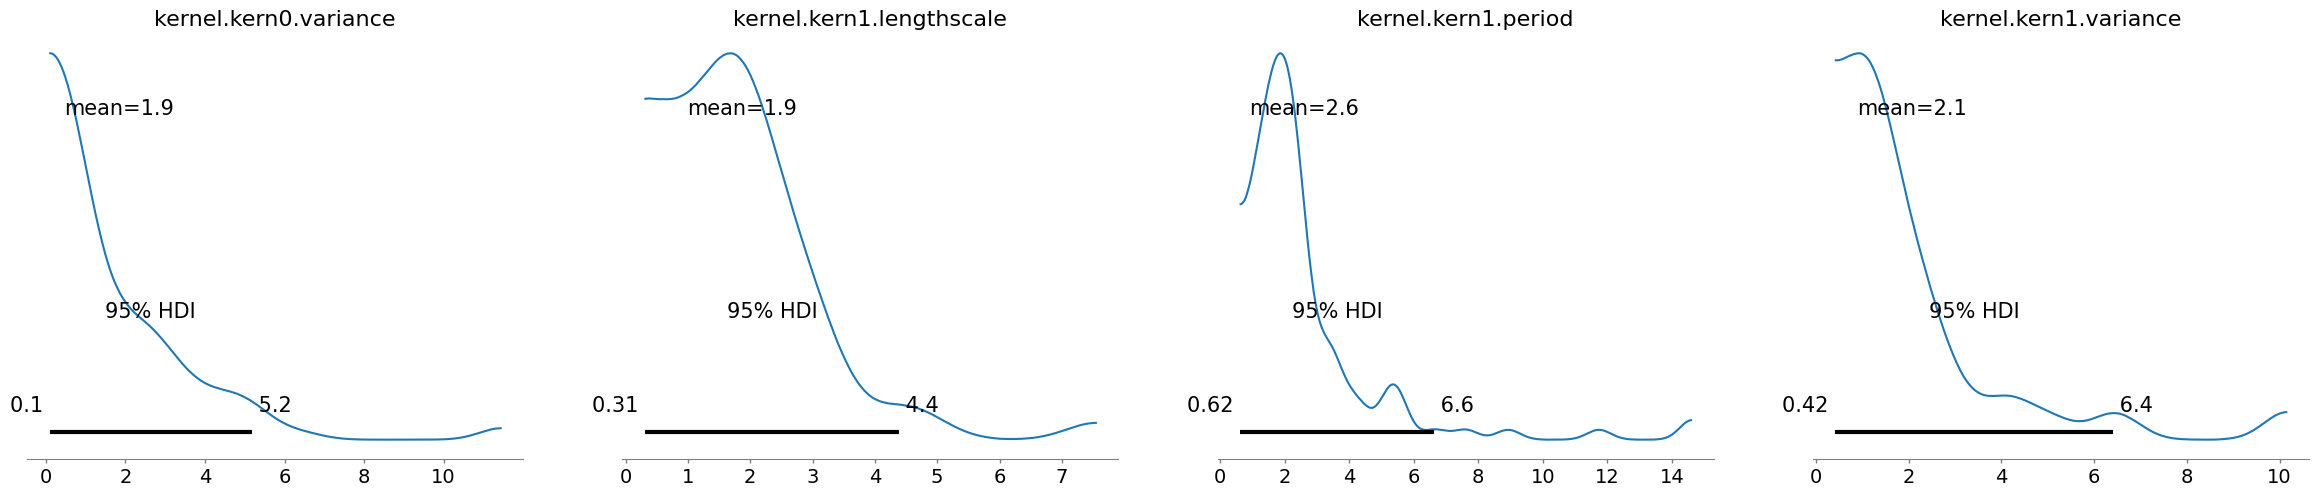

In [831]:
data = arviz.from_pyro(mcmc)
# Specify we want 95% credible interval (hdi=high density interval)
summary = arviz.summary(data, hdi_prob=0.95)
print(summary)
arviz.plot_posterior(data, hdi_prob=0.95)